# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.4.1'

#### Load Image Data

In [7]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 
NUM_FREEZE = 200

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


D:\Program Files\ANACONDA\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=4
)

In [5]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [8]:
print(f"Number of layers in the pretrained model: {len(pretrained.layers)}")

for i in range(NUM_FREEZE):
    pretrained.layers[i].trainable = False

Number of layers in the pretrained model: 311


In [29]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")

In [30]:
training_layers = tf.keras.Sequential([
    # add more layers
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.01)
])

In [31]:
inputs = tf.keras.Input(shape=(None, None, 3))
x = preprocess_input(inputs)
x = pretrained(x)
x = training_layers(x)
dense = tf.keras.layers.Dense(32, activation = 'relu')
x = dense(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
sequential_5 (Sequential)    (None, 128)               13196932  
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 34,999,845
Trainable params: 30,564,037
Non-trainable params: 4,435,808
_______________________________________

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### [5 points] Train Model

In [34]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_batches)

22
6
Epoch 1/100
22/22 [==============================] - 37s 1s/step - loss: 0.5920 - accuracy: 0.7092 - val_loss: 0.5713 - val_accuracy: 0.7500
Epoch 2/100
22/22 [==============================] - 28s 1s/step - loss: 0.5666 - accuracy: 0.7500 - val_loss: 0.5626 - val_accuracy: 0.7500
Epoch 3/100
22/22 [==============================] - 28s 1s/step - loss: 0.5648 - accuracy: 0.7500 - val_loss: 0.5638 - val_accuracy: 0.7500
Epoch 4/100
22/22 [==============================] - 28s 1s/step - loss: 0.5643 - accuracy: 0.7500 - val_loss: 0.5675 - val_accuracy: 0.7500
Epoch 5/100
22/22 [==============================] - 28s 1s/step - loss: 0.5640 - accuracy: 0.7500 - val_loss: 0.5631 - val_accuracy: 0.7500
Epoch 6/100
22/22 [==============================] - 28s 1s/step - loss: 0.5638 - accuracy: 0.7500 - val_loss: 0.5628 - val_accuracy: 0.7500
Epoch 7/100
14/22 [==================>...........] - ETA: 9s - loss: 0.5638 - accuracy: 0.7500 

KeyboardInterrupt: 

#### [5 points] Plot Accuracy and Loss During Training

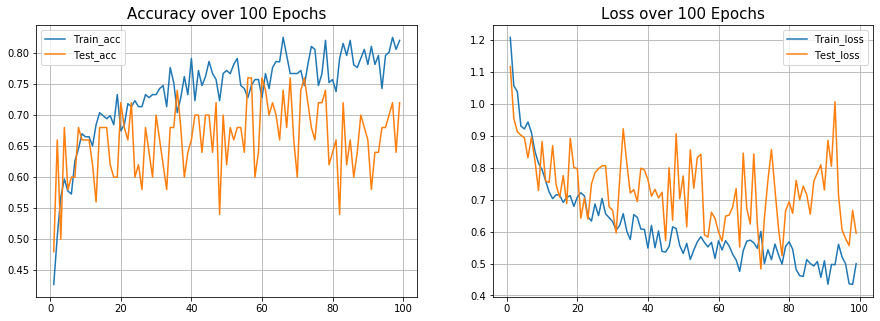

In [7]:
import matplotlib.pyplot as plt

raise NotImplementedError("Plot the accuracy and the loss during training")

#### Testing Model

In [10]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
  ...
    to  
  ['...']
36/36 [==============================] - 10s 274ms/step - loss: 0.7570 - acc: 0.6944
Test loss: 0.757028494571235
Test accuracy: 0.6944444


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Extracting features for 270 images.
270/270 [==============================] - 71s 265ms/step
Training TSNE model.


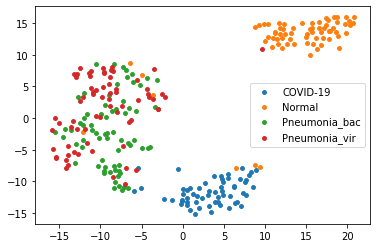

In [15]:
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")

raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
                          "and plot the resulting 2D features of the four classes.")

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->